## Use AI Agent Tools on COCA KWIC results

- https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-openai.html
- https://huggingface.co/openai/gpt-oss-120b


In [1]:
import getout_of_text_3 as got3
import pandas as pd
got3.__version__

'0.4.2'

## Read local offline COCA corpus into workspace

In [2]:
coca_corpus = got3.read_corpus('../../../data/english-corpora.org/coca/')

📚 Detected corpus type: COCA


COCA Genres:   0%|          | 0/8 [00:00<?, ?genre/s]

Processing COCA genre: mag (jgr)


COCA Genres:  12%|█▎        | 1/8 [00:01<00:07,  1.04s/genre]

Finished genre: mag (jgr) - 105,280 texts
Processing COCA genre: web (ywv)


COCA Genres:  25%|██▌       | 2/8 [00:02<00:06,  1.04s/genre]

Finished genre: web (ywv) - 89,052 texts
Processing COCA genre: acad (isi)


COCA Genres:  38%|███▊      | 3/8 [00:03<00:05,  1.05s/genre]

Finished genre: acad (isi) - 26,144 texts
Processing COCA genre: news (nne)


COCA Genres:  50%|█████     | 4/8 [00:04<00:04,  1.23s/genre]

Finished genre: news (nne) - 89,729 texts
Processing COCA genre: spok (yuv)


COCA Genres:  62%|██████▎   | 5/8 [00:06<00:03,  1.28s/genre]

Finished genre: spok (yuv) - 44,857 texts
Processing COCA genre: blog (wih)


COCA Genres:  75%|███████▌  | 6/8 [00:07<00:02,  1.24s/genre]

Finished genre: blog (wih) - 98,788 texts
Processing COCA genre: fic (jjw)


COCA Genres:  88%|████████▊ | 7/8 [00:08<00:01,  1.16s/genre]

Finished genre: fic (jjw) - 25,987 texts
Processing COCA genre: tvm (nwh)


COCA Genres: 100%|██████████| 8/8 [00:09<00:00,  1.17s/genre]

Finished genre: tvm (nwh) - 23,925 texts


## Calculate total word count in the corpus (for reference)

- i.e. COCA is published to have 1.1 billion words 
- `dict_keys(['mag', 'web', 'acad', 'news', 'spok', 'blog', 'fic', 'tvm'])`

In [3]:
# Calculate total word count across all COCA genres and subkeys
def count_words_in_text(text):
    """Count words in a text string."""
    if not isinstance(text, str):
        return 0
    return len(text.split())

# Calculate total word count
total_word_count = 0

print("📊 Calculating total COCA corpus word count...")
start_time=pd.Timestamp.now()
for genre, subkeys in coca_corpus.items():
    for subkey, dataframe in subkeys.items():
        if isinstance(dataframe, pd.DataFrame) and 'text' in dataframe.columns:
            # Count words in all text entries for this subkey
            subkey_word_count = dataframe['text'].apply(count_words_in_text).sum()
            total_word_count += subkey_word_count

end_time=pd.Timestamp.now()
elapsed_time = end_time - start_time
print(f"⏱️ Elapsed time: {elapsed_time}")
print(f"🎯 TOTAL COCA CORPUS: {total_word_count:,} words")

📊 Calculating total COCA corpus word count...
⏱️ Elapsed time: 0 days 00:00:37.417486
🎯 TOTAL COCA CORPUS: 1,178,812,039 words



____________________________
## Simple Demo: Search for a keyword against a local COCA corpus (offline)

- using `landscaping` as a test keyword across the full COCA corpus
- COMPARE YOUR RESULTS TO THE OUTPUT HERE, IF POSSIBLE: https://www.english-corpora.org/coca/
  - I get sometimes less and sometimes more hits! TBD and needs review...
- the `n_jobs` parameter will automatically use n-1 cores to use all but one of your CPU cores. This leads to much better performance on large corpora.

In [4]:
keyword='landscaping'

### Some articles have multiple hits for `landscaping` keyword

- The got3 tool will avoid **dictionary key overwriting** by appending an occurrence counter to the text id key. For example, 15 hits from https://greengurulandscaping.com/business-landscaping-how-to-have-a-good-outdoor-appearance-for-your-business/


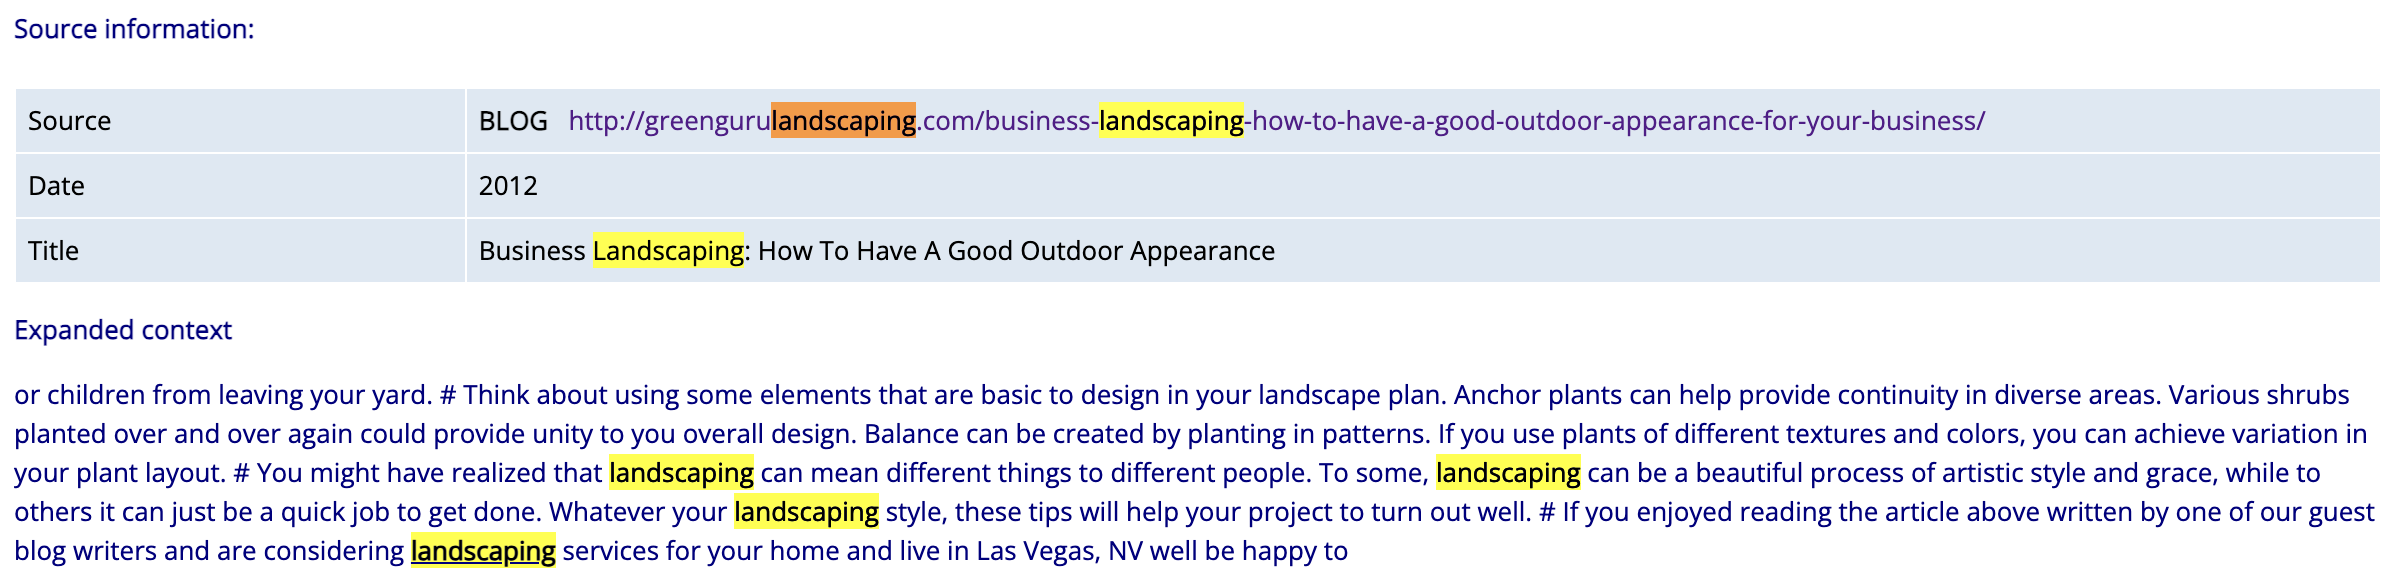

In [5]:
before = pd.Timestamp.now()
kwic_results = got3.search_keyword_corpus(keyword, coca_corpus, 
                                            case_sensitive=False,
                                            show_context=True, 
                                            context_words=15,
                                            output='json',
                                            parallel=True)
after = pd.Timestamp.now()
print('keyword search for `{}` time elapsed:'.format(keyword), after - before)
# Remove keys from kwic_results where the value is an empty dict
kwic_results = {k: v for k, v in kwic_results.items() if v}
print(f"🔍 Found {len(kwic_results)} KWIC genres for keyword '{keyword}'")



keyword search for `landscaping` time elapsed: 0 days 00:00:33.154457
🔍 Found 8 KWIC genres for keyword 'landscaping'


In [7]:
kwic_results['blog_27']['113_1']

KeyError: 'blog_27'

___________________
## 🤖 ⚡️ 🧑‍⚖️ Using AWS Bedrock for GPT-OSS-120B

In response to **Newsom, J., Concurring in Snell v. United Specialty Ins. Co., 102 F.4th 1208 (11th Cir. 2024)** about judges using chatgpt, we iInitialize OpenAI's `GPT-OSS-120B` model (see [here](https://huggingface.co/openai/gpt-oss-120b)) used for SCOTUS analysis now tailored for computational forensic linguistics on COCA data.

### Loading AI Agent Tools

- We are developing an AI agent using Amazon Bedrock models to analyze keyword-in-context (KWIC) results from the COCA (Contemporary Corpus of American English) corpus.

Tools include:
- `CocaForensicLinguisticsTool`: provide filtered KWIC results based on linguistic criteria.

In [26]:
# COCA Computational Forensic Linguistics Agent
# Adapted from SCOTUS analysis tools for corpus linguistics analysis

from langchain.tools import BaseTool
from langchain.pydantic_v1 import BaseModel, Field
from langchain.chat_models import init_chat_model
from typing import Optional, Type, Dict, Any, Union, List
import json
import re
from datetime import datetime

# Initialize AWS Bedrock model for COCA forensic linguistics analysis
model_id = 'openai.gpt-oss-120b-1:0'  # 128K context window
max_tokens = 128000

model = init_chat_model(
    model_id, 
    model_provider="bedrock_converse",
    credentials_profile_name='atn-developer',  # Adjust to your AWS profile (see https://docs.aws.amazon.com/cli/v1/userguide/cli-configure-files.html)
    max_tokens=max_tokens,
    temperature=1.0,
)

# Initialize the COCA forensic linguistics tool
coca_forensic_tool = CocaForensicLinguisticsTool(model=model)

print(f"✅ AWS Bedrock model initialized: {model_id}")
print(f"🔬 COCA Forensic Linguistics Tool ready")
print(f"📊 Available COCA genres: {list(coca_corpus.keys())}")

✅ AWS Bedrock model initialized: openai.gpt-oss-120b-1:0
🔬 COCA Forensic Linguistics Tool ready
📊 Available COCA genres: ['mag', 'web', 'acad', 'news', 'spok', 'blog', 'fic', 'tvm']


### Load Generic Computational Forensic Linguistics Agent Tools

In [27]:
# COCA Computational Forensic Linguistics Agent
# Adapted from SCOTUS analysis tools for corpus linguistics analysis

from langchain.tools import BaseTool
from langchain.pydantic_v1 import BaseModel, Field
from langchain.chat_models import init_chat_model
from typing import Optional, Type, Dict, Any, Union, List
import json
import re
from datetime import datetime


class CocaAnalysisInput(BaseModel):
    """Input for COCA corpus linguistics analysis tool."""
    keyword: str = Field(description="The keyword/phrase to analyze from COCA KWIC results")
    results_json: Union[str, Dict[str, Any]] = Field(
        description="Pre-filtered COCA KWIC JSON results from got3.search_keyword_corpus"
    )
    analysis_focus: Optional[str] = Field(
        default="forensic_linguistics", 
        description="Analysis approach: 'forensic_linguistics', 'semantic_variation', 'register_analysis', 'diachronic', 'comparative'"
    )
    max_contexts: Optional[int] = Field(
        default=None, description="DEPRECATED: No longer used. Tool processes all provided contexts."
    )
    return_json: bool = Field(
        default=False, description="If True, return structured JSON with reasoning and findings"
    )
    extraction_strategy: str = Field(
        default="all",
        description="Text extraction: 'first', 'all', or 'raw_json'"
    )
    debug: bool = Field(default=False, description="Enable debug metrics")


class CocaForensicLinguisticsTool(BaseTool):
    """
    AI tool for computational forensic linguistics analysis of COCA KWIC results.
    
    Applies systematic data science, legal scholarship, and applied linguistics 
    methodologies to analyze keyword usage patterns across COCA genres.
    """
    name: str = "coca_forensic_analysis"
    description: str = (
        "Performs computational forensic linguistics analysis on COCA KWIC results "
        "using data science and applied linguistics methodologies."
    )
    args_schema: Type[BaseModel] = CocaAnalysisInput
    model: Any = Field(exclude=True)

    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self.model = model

    def _run(
        self,
        keyword: str,
        results_json: Union[str, Dict[str, Any]],
        analysis_focus: str = "forensic_linguistics",
        max_contexts: Optional[int] = None,
        return_json: bool = False,
        extraction_strategy: str = "all",
        debug: bool = False,
    ) -> Union[str, Dict[str, Any]]:
        try:
            return self._execute(keyword, results_json, analysis_focus, max_contexts, return_json, extraction_strategy, debug)
        except Exception as e:
            error_str = str(e)
            return f"❌ Error during COCA forensic analysis: {error_str}"

    async def _arun(
        self,
        keyword: str,
        results_json: Union[str, Dict[str, Any]],
        analysis_focus: str = "forensic_linguistics",
        max_contexts: Optional[int] = None,
        return_json: bool = False,
        extraction_strategy: str = "all",
        debug: bool = False,
    ) -> Union[str, Dict[str, Any]]:
        return self._run(keyword, results_json, analysis_focus, max_contexts, return_json, extraction_strategy, debug)

    def _execute(self, keyword, results_json, analysis_focus, max_contexts, return_json, extraction_strategy, debug):
        # Parse and validate input
        results_dict = self._parse_coca_results(results_json)
        stats = self._compute_coca_stats(results_dict, keyword, extraction_strategy)
        
        # Extract contexts and estimate token usage
        contexts = self._extract_contexts(results_dict, max_contexts, extraction_strategy)
        
        # Debug metrics
        if debug:
            print("✅ Reading COCA results for keyword:", keyword)
            raw_chars = len(json.dumps(results_dict))
            extracted_chars = sum(len(c) for c in contexts)
            print(f"🧪 COCA DEBUG: genre_year_keys={len(results_dict)} raw_chars={raw_chars} extracted_chars={extracted_chars} total_contexts={len(contexts)}")
            
            # Debug: Show genre distribution in ALL extracted contexts
            genre_context_counts = {}
            for context in contexts:
                if context.startswith('[') and ':' in context:
                    genre = context.split(':')[0][1:]  # Extract genre from [genre:year:filename]
                    genre_context_counts[genre] = genre_context_counts.get(genre, 0) + 1
            print(f"🎯 All extracted contexts by genre: {genre_context_counts}")
            print(f"📊 Total contexts extracted: {len(contexts)}")
        
        # Build specialized prompt and check token limits
        prompt = self._build_coca_prompt(keyword, results_dict, stats, analysis_focus, max_contexts, return_json, extraction_strategy)
        # Invoke model
        response = self.model.invoke([{"role": "user", "content": prompt}])
        content = getattr(response, 'content', str(response))
        
        if return_json:
            return self._postprocess_coca_json(content, stats)
        return content

    def _parse_coca_results(self, results_json: Union[str, Dict[str, Any]]) -> Dict[str, Any]:
        """Parse COCA results JSON - expects genre->subkey->dataframe structure."""
        if isinstance(results_json, str):
            results_dict = json.loads(results_json)
        else:
            results_dict = results_json
        
        if not isinstance(results_dict, dict):
            raise ValueError("COCA results must be a dict with genre keys")
        return results_dict

    def _extract_contexts(self, results_dict: Dict[str, Any], max_contexts: Optional[int], strategy: str) -> List[str]:
        """Extract ALL context strings from COCA results - no sampling, user controls input."""
        contexts = []
        
        # Handle COCA JSON structure: {genre_year: {filename_id: text_string}}
        for genre_year_key, filename_dict in results_dict.items():
            if not isinstance(filename_dict, dict):
                continue
            
            # Split genre_year for labeling
            parts = genre_year_key.split('_')
            genre = parts[0] if len(parts) >= 1 else 'unknown'
            year = parts[1] if len(parts) >= 2 else 'unknown'
            
            # Extract ALL text content from filename_id -> text_string mappings
            for filename_id, text_content in filename_dict.items():
                if isinstance(text_content, str) and text_content.strip():
                    # Format: [genre:year:filename_id] text_content
                    context_label = f"[{genre}:{year}:{filename_id}]"
                    contexts.append(f"{context_label} {text_content.strip()}")
                        
        return contexts

    def _extract_context_from_row(self, row, strategy: str) -> str:
        """Extract context from a single COCA result row."""
        text_fields = ['context', 'text', 'kwic', 'content', 'snippet']
        
        if strategy == 'first':
            for field in text_fields:
                if hasattr(row, field) and isinstance(getattr(row, field), str):
                    return getattr(row, field).strip()
        elif strategy == 'all':
            parts = []
            for field in text_fields:
                if hasattr(row, field) and isinstance(getattr(row, field), str):
                    parts.append(getattr(row, field).strip())
            return ' | '.join(parts) if parts else ''
        
        return str(row) if strategy == 'raw_json' else ''

    def _extract_context_from_item(self, item, strategy: str) -> str:
        """Extract context from a dict/object item."""
        if isinstance(item, str):
            return item
        elif isinstance(item, dict):
            text_fields = ['context', 'text', 'kwic', 'content', 'snippet']
            if strategy == 'first':
                for field in text_fields:
                    if field in item and isinstance(item[field], str):
                        return item[field].strip()
            elif strategy == 'all':
                parts = []
                for field in text_fields:
                    if field in item and isinstance(item[field], str):
                        parts.append(item[field].strip())
                return ' | '.join(parts) if parts else ''
            elif strategy == 'raw_json':
                return json.dumps(item)
        return str(item)

    def _compute_coca_stats(self, results_dict: Dict[str, Any], keyword: str, strategy: str) -> Dict[str, Any]:
        """Compute statistics about COCA results distribution - handles {genre_year: {filename_id: text_string}} structure."""
        # Extract genres from genre_year keys
        genres = set()
        genre_counts = {}
        total_contexts = 0
        
        for genre_year_key, filename_dict in results_dict.items():
            if isinstance(filename_dict, dict):
                # Split to get genre
                parts = genre_year_key.split('_')
                if len(parts) >= 1:
                    genre = parts[0]
                    genres.add(genre)
                    
                    # Count contexts (filename entries)
                    context_count = len(filename_dict)
                    total_contexts += context_count
                    
                    # Aggregate by genre
                    if genre not in genre_counts:
                        genre_counts[genre] = 0
                    genre_counts[genre] += context_count
        
        return {
            'keyword': keyword,
            'genres': sorted(list(genres)),
            'genre_counts': genre_counts,
            'total_contexts': total_contexts,
            'extraction_strategy': strategy
        }

    def _build_coca_prompt(self, keyword: str, results_dict: Dict[str, Any], stats: Dict[str, Any], 
                          analysis_focus: str, max_contexts: Optional[int], return_json: bool, 
                          extraction_strategy: str) -> str:
        """Build specialized prompt for COCA forensic linguistics analysis."""
        
        contexts = self._extract_contexts(results_dict, max_contexts, extraction_strategy)
        
        # Build genre summary from actual stats, not just what's in contexts
        genre_summary = ", ".join([f"{g}({stats['genre_counts'][g]})" for g in stats['genres']])
        
        # Add explicit instruction about complete data inclusion
        contexts_section = f"""COCA KWIC Contexts (ALL {len(contexts)} contexts from provided data):
---
IMPORTANT: ALL contexts from your provided COCA data are included below: {genre_summary}
Each context is labeled [genre:year:filename_id] to show its source.
No sampling or filtering was performed - this is your complete dataset.
---
""" + "\n".join(contexts) + "\n---\n"
        
        focus_instructions = {
            "forensic_linguistics": """
            As a computational forensic linguist, perform systematic analysis to identify:
            1. **Semantic Range Mapping**: Document all distinct senses/meanings of the keyword
            2. **Register Variation**: Compare usage patterns across genres (academic, news, fiction, etc.)
            3. **Collocational Profiles**: Identify key collocates and their significance
            4. **Frequency Distributions**: Analyze genre-specific frequency patterns
            5. **Interpretive Stability**: Assess semantic consistency vs. context-dependency
            6. **Forensic Implications**: Note patterns relevant to authorship, text dating, or authenticity
            """,
            "semantic_variation": """
            Focus on semantic analysis:
            1. Identify polysemy patterns and meaning boundaries
            2. Map semantic fields and conceptual domains
            3. Analyze metaphorical vs. literal usage
            4. Document semantic change indicators across contexts
            """,
            "register_analysis": """
            Perform register-specific analysis:
            1. Compare formal vs. informal usage patterns
            2. Identify genre-specific conventions
            3. Analyze technical vs. general usage
            4. Map sociolinguistic variation patterns
            """,
            "diachronic": """
            Analyze temporal patterns:
            1. Identify usage evolution across time periods
            2. Map emerging vs. declining meanings
            3. Track semantic change trajectories
            4. Document historical usage patterns
            """,
            "comparative": """
            Perform comparative analysis:
            1. Cross-genre pattern comparison
            2. Usage frequency analysis
            3. Contextual distribution mapping
            4. Identify genre-specific markers
            """
        }
        
        base_prompt = f"""
        You are a computational forensic linguistics AI agent analyzing COCA (Contemporary Corpus of American English) data.

        METHODOLOGICAL FRAMEWORK:
        Apply systematic data science, legal scholarship, and applied linguistics approaches to analyze the keyword "{keyword}".

        CORPUS DATA SUMMARY:
        - Keyword: "{keyword}"
        - Total Contexts Provided: {stats['total_contexts']:,} across {len(results_dict)} genre_year combinations
        - Genre Distribution: {genre_summary}
        - Contexts Analyzed: ALL {len(contexts)} contexts (complete dataset, no sampling)
        - Extraction Strategy: {extraction_strategy}
        
        ANALYSIS FOCUS: {analysis_focus}
        {focus_instructions.get(analysis_focus, focus_instructions['forensic_linguistics'])}

        SYSTEMATIC STEPS:
        1. **Data Overview**: Summarize distribution across ALL genres (use the counts provided above)
        2. **Pattern Recognition**: Identify recurring usage patterns across different genres
        3. **Statistical Analysis**: Note frequency and distribution patterns across ALL genres
        4. **Linguistic Analysis**: Analyze syntactic, semantic, and pragmatic features by genre
        5. **Forensic Assessment**: Evaluate evidential value for text analysis
        6. **Interpretive Framework**: Provide systematic interpretation guidelines

        CRITICAL CONSTRAINTS:
        - Use ALL the provided COCA contexts (complete dataset as provided by user)
        - Apply rigorous linguistic methodology across all provided contexts
        - Avoid speculation beyond evidence
        - Maintain scientific objectivity
        - Analyze the complete distribution of contexts as provided (no sampling performed)

        {contexts_section}
        """
        
        if return_json:
            base_prompt += """
            Return ONLY valid JSON with this structure:
            {
              "keyword": string,
              "total_contexts": number,
              "genre_distribution": object,
              "reasoning_content": [string, ...],
              "semantic_analysis": string,
              "register_patterns": string,
              "forensic_implications": string,
              "summary": string,
              "limitations": string
            }
            """
        else:
            base_prompt += """
            Provide structured analysis with these sections:
            1. **Corpus Distribution Overview** (use the full genre counts provided)
            2. **Semantic Analysis** 
            3. **Register and Genre Patterns** (analyze patterns across ALL genres)
            4. **Collocational Analysis**
            5. **Forensic Linguistics Assessment**
            6. **Interpretive Guidelines**
            7. **Methodological Limitations**
            """
        
        return base_prompt.strip()

    def _postprocess_coca_json(self, content: str, stats: Dict[str, Any]) -> Dict[str, Any]:
        """Process and validate JSON response from model."""
        try:
            parsed = json.loads(content)
        except Exception:
            # Try to extract JSON from response
            match = re.search(r'{[\s\S]*}', content)
            if match:
                try:
                    parsed = json.loads(match.group(0))
                except Exception:
                    parsed = None
            else:
                parsed = None
        
        if not isinstance(parsed, dict):
            # Fallback structure
            parsed = {
                "keyword": stats['keyword'],
                "total_contexts": stats['total_contexts'],
                "genre_distribution": stats['genre_counts'],
                "reasoning_content": [
                    "Model did not return valid JSON; content auto-wrapped.",
                    "Analysis limited by response format issues."
                ],
                "semantic_analysis": content if isinstance(content, str) else str(content),
                "register_patterns": "Unable to extract due to format issues.",
                "forensic_implications": "Analysis inconclusive due to response parsing failure.",
                "summary": "Response required manual wrapping - review raw content.",
                "limitations": "Auto-wrapped due to invalid JSON from model."
            }
        
        # Ensure required fields exist
        required_fields = {
            "reasoning_content": [],
            "semantic_analysis": "",
            "register_patterns": "",
            "forensic_implications": "",
            "summary": "",
            "limitations": ""
        }
        
        for field, default in required_fields.items():
            if field not in parsed:
                parsed[field] = default
        
        return parsed
    
# Markdown export function for COCA analysis
def export_coca_markdown(result, keyword: str, filename: str = None):
    """Export COCA forensic linguistics analysis to markdown with reasoning first."""
    import json
    from datetime import datetime
    
    def _sanitize(name: str) -> str:
        return ''.join(c if (c.isalnum() or c in ('-','_')) else '_' for c in name.strip()) or 'analysis'
    
    safe_keyword = _sanitize(keyword)
    outname = filename or f"coca_forensic_{safe_keyword}.md"
    
    lines = [f"# COCA Forensic Linguistics Analysis: {keyword}\n\n"]
    lines.append(f"*Generated: {datetime.utcnow().isoformat()}Z*\n\n")
    
    if isinstance(result, dict):
        # Extract reasoning content first
        reasoning = result.get('reasoning_content', [])
        if reasoning:
            lines.append("## Methodological Framework\n\n")
            lines.append("```text\n")
            if isinstance(reasoning, list):
                lines.append('\n'.join(str(r) for r in reasoning))
            else:
                lines.append(str(reasoning))
            lines.append("\n```\n\n")
        
        # Add structured sections
        sections = [
            ('semantic_analysis', 'Semantic Analysis'),
            ('register_patterns', 'Register and Genre Patterns'),
            ('forensic_implications', 'Forensic Linguistics Assessment'),
            ('summary', 'Summary'),
            ('limitations', 'Limitations')
        ]
        
        for field, title in sections:
            if field in result and result[field]:
                lines.append(f"## {title}\n\n")
                lines.append(f"{result[field]}\n\n")
        
        # Add distribution data if available
        if 'genre_distribution' in result:
            lines.append("## Corpus Distribution\n\n")
            lines.append("```json\n")
            lines.append(json.dumps(result['genre_distribution'], indent=2))
            lines.append("\n```\n\n")
    
    else:
        lines.append("## Analysis\n\n")
        lines.append(str(result))
    
    content = ''.join(lines)
    
    with open(outname, 'w', encoding='utf-8') as f:
        f.write(content)
    
    print(f"📄 COCA forensic analysis exported: {outname} ({len(content)} chars)")
    return outname

print("✅ COCA Forensic Linguistics Tool loaded!")

✅ COCA Forensic Linguistics Tool loaded!


## COCA Forensic Linguistics Analysis Demo

Let's demonstrate the computational forensic linguistics approach on COCA data using a test keyword.

In [28]:
# First, ensure we have JSON data for analysis (not just print output)
#keyword = "gabagool"
#keyword="best system"
#keyword="foreign tribunal"
keyword="landscaping"
context_window=30
max_tokens=128000
ratio_scale_back=0.5

print(f"🔍 Running COCA KWIC search for JSON analysis: '{keyword}'")

# Re-run the search with output='json' to get structured data for AI analysis
sample_kwic_json = got3.search_keyword_corpus(
    keyword, 
    coca_corpus,
    case_sensitive=False,
    show_context=True, 
    context_words=int(context_window * ratio_scale_back),
    output='json',  # This is key - we need JSON output for AI analysis
    parallel=True
)

print(f"📊 KWIC JSON search complete!")
print(f"🔍 Found data in genres: {list(sample_kwic_json.keys())}")

🔍 Running COCA KWIC search for JSON analysis: 'landscaping'
📊 KWIC JSON search complete!
🔍 Found data in genres: ['mag_1993', 'mag_1992', 'mag_1990', 'mag_1991', 'mag_1995', 'mag_1994', 'mag_1996', 'mag_1997', 'mag_2008', 'mag_2009', 'mag_2019', 'mag_2018', 'mag_2002', 'mag_2016', 'mag_2017', 'mag_2003', 'mag_2015', 'mag_2001', 'mag_2000', 'mag_2014', 'mag_2010', 'mag_2004', 'mag_2005', 'mag_2011', 'mag_2007', 'mag_2013', 'mag_2012', 'mag_2006', 'mag_1999', 'mag_1998', 'web_13', 'web_07', 'web_06', 'web_12', 'web_04', 'web_10', 'web_11', 'web_05', 'web_29', 'web_01', 'web_15', 'web_14', 'web_28', 'web_16', 'web_02', 'web_03', 'web_17', 'web_32', 'web_26', 'web_27', 'web_33', 'web_25', 'web_31', 'web_19', 'web_18', 'web_30', 'web_24', 'web_08', 'web_20', 'web_34', 'web_21', 'web_09', 'web_23', 'web_22', 'acad_2013', 'acad_2007', 'acad_2006', 'acad_2012', 'acad_2004', 'acad_2010', 'acad_2011', 'acad_2005', 'acad_2001', 'acad_2015', 'acad_2014', 'acad_2000', 'acad_2016', 'acad_2002', 'aca

In [29]:
# Remove keys from kwic_results where the value is an empty dict
sample_kwic_json = {k: v for k, v in sample_kwic_json.items() if v}

In [30]:
# Debug: Show all genre_year keys returned by the search
print(f"📋 All genre_year keys found for '{keyword}':")
print("=" * 60)

sorted_keys = sorted(sample_kwic_json.keys())
for i, key in enumerate(sorted_keys, 1):
    hit_count = len(sample_kwic_json[key]) if isinstance(sample_kwic_json[key], dict) else 0
    parts = key.split('_')
    genre = parts[0] if len(parts) >= 1 else 'unknown'
    year = parts[1] if len(parts) >= 2 else 'unknown'
    print(f"  {i:2}. {key} -> {hit_count:,} hits (genre: {genre}, year: {year})")

print(f"\n🎯 Total genre_year combinations: {len(sorted_keys)}")

# Show genre and year diversity
genres = set()
years = set()
for key in sorted_keys:
    parts = key.split('_')
    if len(parts) >= 2:
        genres.add(parts[0])
        years.add(parts[1])

print(f"📊 Unique genres found: {sorted(genres)}")
print(f"📅 Unique years found: {sorted(years)}")

📋 All genre_year keys found for 'landscaping':
   1. acad_1990 -> 2 hits (genre: acad, year: 1990)
   2. acad_1991 -> 1 hits (genre: acad, year: 1991)
   3. acad_1992 -> 3 hits (genre: acad, year: 1992)
   4. acad_1993 -> 8 hits (genre: acad, year: 1993)
   5. acad_1994 -> 4 hits (genre: acad, year: 1994)
   6. acad_1995 -> 12 hits (genre: acad, year: 1995)
   7. acad_1996 -> 10 hits (genre: acad, year: 1996)
   8. acad_1997 -> 6 hits (genre: acad, year: 1997)
   9. acad_1998 -> 19 hits (genre: acad, year: 1998)
  10. acad_1999 -> 14 hits (genre: acad, year: 1999)
  11. acad_2000 -> 12 hits (genre: acad, year: 2000)
  12. acad_2001 -> 13 hits (genre: acad, year: 2001)
  13. acad_2002 -> 3 hits (genre: acad, year: 2002)
  14. acad_2003 -> 7 hits (genre: acad, year: 2003)
  15. acad_2004 -> 6 hits (genre: acad, year: 2004)
  16. acad_2005 -> 3 hits (genre: acad, year: 2005)
  17. acad_2006 -> 4 hits (genre: acad, year: 2006)
  18. acad_2007 -> 10 hits (genre: acad, year: 2007)
  19. acad

In [31]:
import random
import pandas as pd

# Comprehensive COCA bovine data analysis
print("📊 COCA '{}' Distribution Analysis".format(keyword))
print("=" * 50)

# Analyze the structure: {genre_year: {filename_id: text_string}}
genre_year_counts = {}
total_hits = 0

# Count hits per genre_year combination
for genre_year_key, filename_dict in sample_kwic_json.items():
    # Count the number of filename entries (each represents a hit)
    hit_count = len(filename_dict) if isinstance(filename_dict, dict) else 0
    genre_year_counts[genre_year_key] = hit_count
    total_hits += hit_count

print(f"🎯 Total hits: {total_hits:,}")
print(f"📋 Total genre_year combinations: {len(genre_year_counts)}")

# 1. GENRE TOTALS (split on '_' and aggregate by genre [0])
print(f"\n📈 Hits by GENRE (total across all years):")
genre_totals = {}
for genre_year_key, hit_count in genre_year_counts.items():
    # Split on '_' and take first part as genre
    parts = genre_year_key.split('_')
    if len(parts) >= 2:
        genre = parts[0]  # First part is genre
        if genre not in genre_totals:
            genre_totals[genre] = 0
        genre_totals[genre] += hit_count

for genre, total in sorted(genre_totals.items(), key=lambda x: x[1], reverse=True):
    percentage = (total / total_hits * 100) if total_hits > 0 else 0
    print(f"  {genre}: {total:,} hits ({percentage:.1f}%)")

# 2. YEAR TOTALS (split on '_' and aggregate by year [1])
print(f"\n📅 Hits by YEAR (total across all genres):")
year_totals = {}
for genre_year_key, hit_count in genre_year_counts.items():
    # Split on '_' and take second part as year
    parts = genre_year_key.split('_')
    if len(parts) >= 2:
        year = parts[1]  # Second part is year
        if year not in year_totals:
            year_totals[year] = 0
        year_totals[year] += hit_count

# Sort years by hit count (top 15)
for year, total in sorted(year_totals.items(), key=lambda x: x[1], reverse=True)[:15]:
    percentage = (total / total_hits * 100) if total_hits > 0 else 0
    print(f"  {year}: {total:,} hits ({percentage:.1f}%)")

# 3. TOP 10 GENRE_YEAR combinations by hit count
print(f"\n🔥 Top 10 genre_year combinations by hit count:")
sorted_counts = sorted(genre_year_counts.items(), key=lambda x: x[1], reverse=True)
for i, (genre_year_key, count) in enumerate(sorted_counts[:10], 1):
    parts = genre_year_key.split('_')
    genre = parts[0] if len(parts) >= 1 else 'unknown'
    year = parts[1] if len(parts) >= 2 else 'unknown'
    print(f"  {i:2}. {genre_year_key}: {count:,} hits (genre: {genre}, year: {year})")

# 4. Random example for inspection
print(f"\n🎲 Random Example Context:")
print("=" * 30)

# Only select from genre_year combinations that have actual data
non_empty_keys = [key for key, filename_dict in sample_kwic_json.items() 
                  if isinstance(filename_dict, dict) and len(filename_dict) > 0]

if non_empty_keys:
    random_genre_year = random.choice(non_empty_keys)
    random_filename_id = random.choice(list(sample_kwic_json[random_genre_year].keys()))
    random_text = sample_kwic_json[random_genre_year][random_filename_id]

    parts = random_genre_year.split('_')
    genre = parts[0] if len(parts) >= 1 else 'unknown'
    year = parts[1] if len(parts) >= 2 else 'unknown'

    print(f"Genre_Year Key: {random_genre_year}")
    print(f"  - Genre: {genre}")
    print(f"  - Year: {year}")
    print(f"Filename ID: {random_filename_id}")
    print(f"Total hits in this genre_year: {genre_year_counts.get(random_genre_year, 0):,}")
    print(f"\nSample text content:")
    print(f"{str(random_text)[:200]}..." if len(str(random_text)) > 200 else str(random_text))
else:
    print("❌ No genre_year combinations contain actual hit data")

📊 COCA 'landscaping' Distribution Analysis
🎯 Total hits: 2,149
📋 Total genre_year combinations: 239

📈 Hits by GENRE (total across all years):
  news: 596 hits (27.7%)
  mag: 478 hits (22.2%)
  blog: 296 hits (13.8%)
  fic: 231 hits (10.7%)
  acad: 174 hits (8.1%)
  web: 166 hits (7.7%)
  tvm: 124 hits (5.8%)
  spok: 84 hits (3.9%)

📅 Hits by YEAR (total across all genres):
  2007: 92 hits (4.3%)
  2015: 87 hits (4.0%)
  2004: 85 hits (4.0%)
  2005: 80 hits (3.7%)
  1998: 76 hits (3.5%)
  2008: 68 hits (3.2%)
  2009: 68 hits (3.2%)
  2001: 66 hits (3.1%)
  2006: 66 hits (3.1%)
  2013: 64 hits (3.0%)
  2012: 64 hits (3.0%)
  2003: 62 hits (2.9%)
  1997: 61 hits (2.8%)
  2000: 59 hits (2.7%)
  2014: 56 hits (2.6%)

🔥 Top 10 genre_year combinations by hit count:
   1. news_2015: 42 hits (genre: news, year: 2015)
   2. blog_27: 38 hits (genre: blog, year: 27)
   3. mag_2007: 35 hits (genre: mag, year: 2007)
   4. mag_2004: 29 hits (genre: mag, year: 2004)
   5. news_2005: 29 hits (genre: n

In [32]:
print(f"🔍 Found data in genres: {list(sample_kwic_json.keys())}")

🔍 Found data in genres: ['mag_1993', 'mag_1992', 'mag_1990', 'mag_1991', 'mag_1995', 'mag_1994', 'mag_1996', 'mag_1997', 'mag_2008', 'mag_2009', 'mag_2019', 'mag_2018', 'mag_2002', 'mag_2016', 'mag_2017', 'mag_2003', 'mag_2015', 'mag_2001', 'mag_2000', 'mag_2014', 'mag_2010', 'mag_2004', 'mag_2005', 'mag_2011', 'mag_2007', 'mag_2013', 'mag_2012', 'mag_2006', 'mag_1999', 'mag_1998', 'web_13', 'web_07', 'web_06', 'web_12', 'web_04', 'web_10', 'web_11', 'web_05', 'web_29', 'web_01', 'web_15', 'web_14', 'web_28', 'web_16', 'web_02', 'web_03', 'web_17', 'web_32', 'web_26', 'web_27', 'web_33', 'web_25', 'web_31', 'web_19', 'web_18', 'web_30', 'web_24', 'web_08', 'web_20', 'web_34', 'web_21', 'web_09', 'web_23', 'web_22', 'acad_2013', 'acad_2007', 'acad_2006', 'acad_2012', 'acad_2004', 'acad_2010', 'acad_2011', 'acad_2005', 'acad_2001', 'acad_2015', 'acad_2014', 'acad_2000', 'acad_2016', 'acad_2002', 'acad_2003', 'acad_1999', 'acad_1998', 'acad_1996', 'acad_1997', 'acad_1995', 'acad_1994', 'a

In [33]:
# flatten the bovine_kwic_json to string and get its length
len(json.dumps(sample_kwic_json))

397028

In [34]:
analysis_result = coca_forensic_tool._run(
    keyword=keyword,
    results_json=sample_kwic_json,  # Use the JSON data
    analysis_focus="forensic_linguistics",
    #max_contexts=50,  # Limit for demo
    return_json=False,
    extraction_strategy="all",
    debug=True
)

✅ Reading COCA results for keyword: landscaping
🧪 COCA DEBUG: genre_year_keys=239 raw_chars=397028 extracted_chars=401887 total_contexts=2149
🎯 All extracted contexts by genre: {'mag': 478, 'web': 166, 'acad': 174, 'news': 596, 'spok': 84, 'blog': 296, 'fic': 231, 'tvm': 124}
📊 Total contexts extracted: 2149


In [36]:
# Enhanced COCA markdown export function to handle structured block responses
def export_coca_markdown_blocks(result, keyword: str, filename: str = None):
    """
    Export COCA forensic linguistics analysis to markdown, handling both dict and list formats.
    
    This function can process:
    - Dictionary results (JSON mode)
    - List of blocks (typical LangChain/Bedrock response format)
    - Simple string results
    """
    import json
    from datetime import datetime
    
    def _sanitize(name: str) -> str:
        return ''.join(c if (c.isalnum() or c in ('-','_')) else '_' for c in name.strip()) or 'analysis'
    
    safe_keyword = _sanitize(keyword)
    outname = filename or f"coca_forensic_{safe_keyword}_blocks.md"
    
    lines = [f"# COCA Forensic Linguistics Analysis: {keyword}\n\n"]
    lines.append(f"*Generated: {datetime.utcnow().isoformat()}Z*\n\n")
    
    # Handle different result formats
    if isinstance(result, list):
        # Extract reasoning content and main text from blocks
        reasoning_parts = []
        main_text_parts = []
        
        for block in result:
            if isinstance(block, dict):
                # Check for reasoning content
                if block.get('type') == 'reasoning_content':
                    rc = block.get('reasoning_content', {})
                    if isinstance(rc, dict) and 'text' in rc:
                        reasoning_parts.append(rc['text'])
                    elif isinstance(rc, str):
                        reasoning_parts.append(rc)
                
                # Check for main text content
                if block.get('type') == 'text' and 'text' in block:
                    main_text_parts.append(block['text'])
                elif 'text' in block and block.get('type') != 'reasoning_content':
                    main_text_parts.append(block['text'])
            elif isinstance(block, str):
                main_text_parts.append(block)
        
        # Add reasoning framework if found
        if reasoning_parts:
            lines.append("## Methodological Framework\n\n")
            lines.append("```text\n")
            lines.append('\n\n'.join(reasoning_parts))
            lines.append("\n```\n\n")
        
        # Add main analysis
        if main_text_parts:
            lines.append("## Analysis\n\n")
            lines.append('\n\n'.join(main_text_parts))
            lines.append("\n\n")
    
    elif isinstance(result, dict):
        # Handle dictionary format (existing logic)
        reasoning = result.get('reasoning_content', [])
        if reasoning:
            lines.append("## Methodological Framework\n\n")
            lines.append("```text\n")
            if isinstance(reasoning, list):
                lines.append('\n'.join(str(r) for r in reasoning))
            else:
                lines.append(str(reasoning))
            lines.append("\n```\n\n")
        
        # Add structured sections
        sections = [
            ('semantic_analysis', 'Semantic Analysis'),
            ('register_patterns', 'Register and Genre Patterns'),
            ('forensic_implications', 'Forensic Linguistics Assessment'),
            ('summary', 'Summary'),
            ('limitations', 'Limitations')
        ]
        
        for field, title in sections:
            if field in result and result[field]:
                lines.append(f"## {title}\n\n")
                lines.append(f"{result[field]}\n\n")
        
        # Add distribution data if available
        if 'genre_distribution' in result:
            lines.append("## Corpus Distribution\n\n")
            lines.append("```json\n")
            lines.append(json.dumps(result['genre_distribution'], indent=2))
            lines.append("\n```\n\n")
    
    else:
        # Handle simple string format
        lines.append("## Analysis\n\n")
        lines.append(str(result))
        lines.append("\n\n")
    
    # Add metadata footer
    lines.append("---\n\n")
    lines.append(f"*Analysis completed using COCA Forensic Linguistics Tool*\n")
    lines.append(f"*Keyword: {keyword} | Export timestamp: {datetime.utcnow().isoformat()}Z*\n")
    
    content = ''.join(lines)
    
    with open(outname, 'w', encoding='utf-8') as f:
        f.write(content)
    
    print(f"📄 Enhanced COCA forensic analysis exported: {outname} ({len(content)} chars)")
    return outname

# Re-export the register analysis with the enhanced function
if 'register_analysis' in locals():
    print("🔄 Re-exporting register analysis with enhanced block parser...")
    export_coca_markdown_blocks(register_analysis, f"{test_keyword}_register_fixed")
else:
    print("❌ No register_analysis variable found to re-export")

❌ No register_analysis variable found to re-export


In [37]:
export_coca_markdown_blocks(analysis_result, keyword, f"{keyword}_forensic_analysis{pd.Timestamp.now().strftime('_%Y%m%d_%H%M%S')}.md")

📄 Enhanced COCA forensic analysis exported: landscaping_forensic_analysis_20251103_202412.md (17014 chars)


'landscaping_forensic_analysis_20251103_202412.md'

_________________
# BYU Law & Corpus Linguistics 10th Annual Conference
## Lee & Egbert Classification Tool

Following the Lee & Egbert methodology for analyzing "landscaping" in COCA, we'll create a specialized AI tool that:

1. Takes KWIC concordance lines as input
2. Classifies each occurrence according to four criteria:
   - Whether it includes botanical elements (Yes/No/Indeterminate)
   - Whether it includes non-botanical elements (Yes/No/Indeterminate)
   - Whether it improves aesthetics (Yes/No/Indeterminate)
   - Whether it improves function (Yes/No/Indeterminate)
3. Returns structured data suitable for analysis

**Key Constraint**: Rely only on text-internal evidence from the concordance line itself.

**PRE-PRINT FROM LAW & CL CONFERENCE AT BYU**
- Legal interpretation with GenAI-assisted lexical semantics (Jesse Egbert, Northern Arizona University, Thomas R. Lee, Brigham Young University)

    > "The attached spreadsheet contains 1,000 concordance lines for the word “landscaping”
    extracted from the Corpus of Contemporary American English. Using the linguistic context
    within these concordance lines, code the meaning of each use of "landscaping" for the
    following: (1) whether it includes botanical elements; (2) whether it includes non-botanical
    elements; (3) whether it improves aesthetics; and (4) whether it improves function. Rely
    only on text-internal evidence, meaning there must be evidence in the concordance line
    itself regarding the language user's understanding of the meaning of landscaping. In the 
    appropriate columns, include "Yes", "No", or "Indeterminate" (in cases where there is
    insufficient text-internal evidence to know). Save this in .xlsx format and return it to me as
    an attachment."

We'd like to apply their workflow (i.e. in this case, taking all the KWIC concordance lines for the term `landscaping` in COCA) and use an AI agent to classify each occurrence according to the four criteria mentioned above. Their study is limited in that they are using commercial offerings for AI Chatbots, but the approach can be better supported by using Agentic AI tools with access to the full COCA data.

In [85]:
# Lee & Egbert COCA Classification Tool
# Designed to replicate and improve upon their landscaping semantic analysis methodology

from langchain.tools import BaseTool
from langchain.pydantic_v1 import BaseModel, Field
from langchain.chat_models import init_chat_model
from typing import Optional, Type, Dict, Any, Union, List
import json
import pandas as pd
from datetime import datetime
import os
from pathlib import Path


class LeeEgbertClassificationInput(BaseModel):
    """Input for Lee & Egbert-style concordance line classification."""
    keyword: str = Field(description="The keyword being analyzed (e.g., 'landscaping')")
    results_json: Union[str, Dict[str, Any]] = Field(
        description="COCA KWIC JSON results from got3.search_keyword_corpus"
    )
    classification_criteria: Optional[List[str]] = Field(
        default=None,
        description="Custom criteria to classify. If None, uses default 4 criteria for 'landscaping'"
    )
    batch_size: Optional[int] = Field(
        default=100, 
        description="Number of concordance lines to process per batch"
    )
    reasoning_level: Optional[str] = Field(
        default="high", 
        description="Level of reasoning detail for gpt-oss model (tradeoff of speed vs accuracy): 'high', 'medium', 'low'"
    )
    return_dataframe: bool = Field(
        default=True, 
        description="If True, return pandas DataFrame; if False, return list of dicts"
    )
    cache_dir: Optional[str] = Field(
        default="./cache/lee_egbert_classifications",
        description="Directory to cache batch results (prevents loss on failure)"
    )
    use_cache: bool = Field(
        default=True,
        description="If True, use cached results and resume from last completed batch"
    )
    debug: bool = Field(default=False, description="Enable debug output")


class LeeEgbertClassificationTool(BaseTool):
    """
    AI tool for classifying COCA concordance lines following Lee & Egbert methodology.
    
    Performs semantic classification based solely on text-internal evidence within
    each concordance line. Returns structured classifications suitable for 
    quantitative analysis.
    
    Features resilient caching to prevent loss of expensive API calls on failure.
    """
    name: str = "lee_egbert_classification"
    description: str = (
        "Classifies COCA concordance lines according to semantic criteria "
        "using only text-internal evidence, following Lee & Egbert methodology."
    )
    args_schema: Type[BaseModel] = LeeEgbertClassificationInput
    model: Any = Field(exclude=True)

    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self.model = model

    def _run(
        self,
        keyword: str,
        results_json: Union[str, Dict[str, Any]],
        classification_criteria: Optional[List[str]] = None,
        reasoning_level: str = "high",
        batch_size: int = 100,
        return_dataframe: bool = True,
        cache_dir: str = "./cache/lee_egbert_classifications",
        use_cache: bool = True,
        debug: bool = False,
    ) -> Union[pd.DataFrame, List[Dict[str, Any]], str]:
        try:
            return self._execute(keyword, results_json, classification_criteria, reasoning_level,
                               batch_size, return_dataframe, cache_dir, use_cache, debug)
        except Exception as e:
            return f"❌ Error during Lee & Egbert classification: {str(e)}"

    async def _arun(
        self,
        keyword: str,
        results_json: Union[str, Dict[str, Any]],
        classification_criteria: Optional[List[str]] = None,
        reasoning_level: Optional[str] = None,
        batch_size: int = 100,
        return_dataframe: bool = True,
        cache_dir: str = "./cache/lee_egbert_classifications",
        use_cache: bool = True,
        debug: bool = False,
    ) -> Union[pd.DataFrame, List[Dict[str, Any]], str]:
        return self._run(keyword, results_json, classification_criteria, reasoning_level,
                          batch_size, return_dataframe, cache_dir, use_cache, debug)

    def _execute(self, keyword, results_json, classification_criteria, reasoning_level,
                batch_size, return_dataframe, cache_dir, use_cache, debug):
        # Parse input
        results_dict = self._parse_coca_results(results_json)
        
        # Extract all concordance lines with metadata
        concordance_lines = self._extract_concordance_lines(results_dict, keyword)
        
        if debug:
            print(f"✅ Extracted {len(concordance_lines)} concordance lines for '{keyword}'")
            print(f"📊 Processing in batches of {batch_size}")
        
        # Set default criteria if not provided
        if classification_criteria is None:
            classification_criteria = [
                "includes_botanical_elements",
                "includes_non_botanical_elements", 
                "improves_aesthetics",
                "improves_function"
            ]
        
        # Set default to medium reasoning level as default
        if reasoning_level not in ['high', 'medium', 'low']:
            reasoning_level = 'medium'
        
        # Setup cache directory
        cache_path = Path(cache_dir)
        if use_cache:
            cache_path.mkdir(parents=True, exist_ok=True)
            session_id = datetime.now().strftime("%Y%m%d_%H%M%S")
            cache_prefix = f"{keyword}_{reasoning_level}_b{batch_size}_{session_id}"
            if debug:
                print(f"💾 Cache enabled: {cache_path / cache_prefix}_*.json")
        
        # Check for existing cache files and load them
        all_classifications = []
        completed_batches = set()
        
        if use_cache:
            existing_caches = list(cache_path.glob(f"{keyword}_{reasoning_level}_b{batch_size}_*_batch_*.json"))
            if existing_caches:
                print(f"📂 Found {len(existing_caches)} cached batch files")
                for cache_file in sorted(existing_caches):
                    try:
                        with open(cache_file, 'r') as f:
                            cached_batch = json.load(f)
                            all_classifications.extend(cached_batch['classifications'])
                            completed_batches.add(cached_batch['batch_num'])
                        if debug:
                            cache_file_name = cache_file.name
                            #print(f"  ✅ Loaded batch {cached_batch['batch_num']} from cache")
                    except Exception as e:
                        print(f"  ⚠️ Failed to load {cache_file.name}: {e}")
                
                if completed_batches:
                    print(f"♻️ Resuming from batch {max(completed_batches) + 1} (loaded {len(all_classifications)} classifications)")
        
        # Process in batches with tqdm progress bar
        from tqdm.auto import tqdm
        
        total_batches = (len(concordance_lines) + batch_size - 1) // batch_size
        
        # Create progress bar
        pbar = tqdm(
            total=total_batches,
            desc=f"Classifying '{keyword}'",
            unit="batch",
            initial=len(completed_batches)
        )
        
        for batch_idx in range(0, len(concordance_lines), batch_size):
            batch_num = (batch_idx // batch_size) + 1
            
            # Skip if this batch was already completed
            if batch_num in completed_batches:
                continue
            
            batch = concordance_lines[batch_idx:batch_idx + batch_size]
            
            # Update progress bar description with current batch info
            pbar.set_postfix({'lines': len(batch), 'batch': f'{batch_num}/{total_batches}'})
            
            # Classify this batch
            batch_results = self._classify_batch(keyword, batch, reasoning_level, classification_criteria, debug)
            all_classifications.extend(batch_results)
            
            # Cache this batch immediately
            if use_cache:
                cache_filename = f"{cache_prefix}_batch_{batch_num:04d}.json"
                cache_filepath = cache_path / cache_filename
                try:
                    cache_data = {
                        'keyword': keyword,
                        'reasoning_level': reasoning_level,
                        'batch_size': batch_size,
                        'batch_num': batch_num,
                        'total_batches': total_batches,
                        'timestamp': datetime.now().isoformat(),
                        'classifications': batch_results
                    }
                    with open(cache_filepath, 'w') as f:
                        json.dump(cache_data, f, indent=2)
                except Exception as e:
                    if debug:
                        print(f"  ⚠️ Failed to cache batch {batch_num}: {e}")
            
            # Update progress bar
            pbar.update(1)
        
        pbar.close()
        
        if debug:
            print(f"✅ Classification complete: {len(all_classifications)} lines classified")
        
        # Return as DataFrame or list
        if return_dataframe:
            return pd.DataFrame(all_classifications)
        return all_classifications

    def _parse_coca_results(self, results_json: Union[str, Dict[str, Any]]) -> Dict[str, Any]:
        """Parse COCA results JSON."""
        if isinstance(results_json, str):
            return json.loads(results_json)
        return results_json

    def _extract_concordance_lines(self, results_dict: Dict[str, Any], keyword: str) -> List[Dict[str, Any]]:
        """
        Extract all concordance lines with metadata from COCA results.
        Structure: {genre_year: {filename_id: text_string}}
        Includes text sanitization to prevent malformed input.
        """
        concordance_lines = []
        line_id = 1
        
        for genre_year_key, filename_dict in results_dict.items():
            if not isinstance(filename_dict, dict):
                continue
            
            # Parse genre and year from key
            parts = genre_year_key.split('_')
            genre = parts[0] if len(parts) >= 1 else 'unknown'
            year = parts[1] if len(parts) >= 2 else 'unknown'
            
            for filename_id, text_content in filename_dict.items():
                if isinstance(text_content, str) and text_content.strip():
                    # Sanitize text: remove control characters, normalize whitespace
                    sanitized_text = self._sanitize_text(text_content)
                    
                    # Skip if text is too short or too long after sanitization
                    if len(sanitized_text) < 10 or len(sanitized_text) > 5000:
                        continue
                    
                    concordance_lines.append({
                        'line_id': line_id,
                        'genre': genre,
                        'year': year,
                        'genre_year': genre_year_key,
                        'filename_id': filename_id,
                        'concordance_line': sanitized_text,
                        'keyword': keyword
                    })
                    line_id += 1
        
        return concordance_lines
    
    def _sanitize_text(self, text: str) -> str:
        """Sanitize text to remove problematic characters and normalize whitespace."""
        import re
        
        # Remove control characters except newlines and tabs
        text = ''.join(char for char in text if ord(char) >= 32 or char in '\n\t')
        
        # Normalize whitespace (multiple spaces to single space)
        text = re.sub(r'\s+', ' ', text)
        
        # Remove any NULL bytes
        text = text.replace('\x00', '')
        
        # Strip leading/trailing whitespace
        return text.strip()

    def _classify_batch(self, keyword: str, batch: List[Dict[str, Any]], reasoning_level: str,
                       criteria: List[str], debug: bool) -> List[Dict[str, Any]]:
        """Classify a batch of concordance lines using the AI model with timeout protection."""
        
        # Build prompt for batch classification
        prompt = self._build_classification_prompt(keyword, batch, reasoning_level, criteria)
        
        # Invoke model with timeout protection
        import signal
        from contextlib import contextmanager
        
        @contextmanager
        def timeout(seconds):
            """Context manager for timeout handling."""
            def timeout_handler(signum, frame):
                raise TimeoutError(f"Model invocation timed out after {seconds} seconds")
            
            # Set the signal handler and alarm
            old_handler = signal.signal(signal.SIGALRM, timeout_handler)
            signal.alarm(seconds)
            try:
                yield
            finally:
                signal.alarm(0)
                signal.signal(signal.SIGALRM, old_handler)
        
        try:
            # Set timeout to 120 seconds (2 minutes) per batch
            with timeout(120):
                response = self.model.invoke([{"role": "user", "content": prompt}])
        except TimeoutError as e:
            if debug:
                print(f"  ⚠️ Timeout: {e}")
                print(f"  📝 Batch lines: {[line['line_id'] for line in batch]}")
            # Return batch with timeout error
            classifications = []
            for line in batch:
                classification = {
                    'line_id': line['line_id'],
                    'genre': line['genre'],
                    'year': line['year'],
                    'filename_id': line['filename_id'],
                    'concordance_line': line['concordance_line'],
                    'keyword': line['keyword']
                }
                for criterion in criteria:
                    classification[criterion] = 'Indeterminate'
                classification['error'] = f'Timeout after 120 seconds'
                classifications.append(classification)
            return classifications
        except Exception as e:
            if debug:
                print(f"  ⚠️ Model invocation error: {e}")
                print(f"  📝 Batch lines: {[line['line_id'] for line in batch]}")
            # Return batch with error
            classifications = []
            for line in batch:
                classification = {
                    'line_id': line['line_id'],
                    'genre': line['genre'],
                    'year': line['year'],
                    'filename_id': line['filename_id'],
                    'concordance_line': line['concordance_line'],
                    'keyword': line['keyword']
                }
                for criterion in criteria:
                    classification[criterion] = 'Indeterminate'
                classification['error'] = f'Model error: {str(e)}'
                classifications.append(classification)
            return classifications
        
        # Extract content from response - handle Bedrock response structure
        content = response.content if hasattr(response, 'content') else str(response)
        
        # Parse JSON response
        try:
            classifications = self._parse_classification_response(content, batch, criteria)
        except Exception as e:
            if debug:
                print(f"⚠️ Failed to parse batch classification: {e}")
                print(f"Content type: {type(content)}")
                if isinstance(content, (str, list)):
                    print(f"Raw response (first 500 chars): {str(content)[:500]}")
            # Return batch with all "Indeterminate" if parsing fails
            classifications = []
            for line in batch:
                classification = {
                    'line_id': line['line_id'],
                    'genre': line['genre'],
                    'year': line['year'],
                    'filename_id': line['filename_id'],
                    'concordance_line': line['concordance_line'],
                    'keyword': line['keyword']
                }
                for criterion in criteria:
                    classification[criterion] = 'Indeterminate'
                classification['error'] = f'Failed to parse model response: {str(e)}'
                classifications.append(classification)
        
        return classifications

    def _build_classification_prompt(self, keyword: str, batch: List[Dict[str, Any]], reasoning_level: str,
                                    criteria: List[str]) -> str:
        """Build the classification prompt following Lee & Egbert methodology."""
        
        # Map criteria to natural language descriptions
        criteria_descriptions = {
            "includes_botanical_elements": "whether it includes botanical elements (plants, trees, flowers, grass, etc.)",
            "includes_non_botanical_elements": "whether it includes non-botanical elements (hardscaping, structures, rocks, pavers, etc.)",
            "improves_aesthetics": "whether it improves aesthetics (visual appeal, beauty, appearance)",
            "improves_function": "whether it improves function (practical use, drainage, erosion control, access)"
        }
        
        criteria_list = []
        for i, criterion in enumerate(criteria, 1):
            desc = criteria_descriptions.get(criterion, criterion.replace('_', ' '))
            criteria_list.append(f"  {i}. **{criterion}**: {desc}")
        
        criteria_text = "\n".join(criteria_list)
        
        # Build concordance lines section
        lines_text = []
        for line in batch:
            lines_text.append(f"Line {line['line_id']}: {line['concordance_line']}")
        
        prompt = f"""
You are a Computational Forensic Linguist analyst helping legal scholars (lawyers, judges, professors) along with linguist (corpus linguists, forensic linguists, applied linguists)
You are configured to examine concordance lines (i.e. KWIC, keyword-in-context) for the keyword "{keyword}".
The concordance samples provided were retrieved from the Corpus of Contemporary American English (COCA, see https://www.english-corpora.org/coca/)
This keyword is important here as this represents an ambiguous term in a statute that is being interpreted in a legal context.


# SYSTEM CONFIGURATION:
Reasoning: {reasoning_level}
Docket: Snell v. United Specialty Insurance Company, No. 22-12581 (11th Cir. 2024)
Justia: https://law.justia.com/cases/federal/appellate-courts/ca11/22-12581/22-12581-2024-05-28.html
PDF: https://media.ca11.uscourts.gov/opinions/pub/files/202212581.pdf
ISSUE OF STATUTORY INTERPRETATION: It is unclear if the term "{keyword}" encompasses an in-ground trampolines, which is why are are interesting in anylyzing based on the criteria characteristics provided below.
TASK: Classify each concordance line for the keyword "{keyword}" according to the following criteria:

{criteria_text}

CRITICAL INSTRUCTIONS:
1. **Text-Internal Evidence Only**: Base your classification SOLELY on evidence present in the concordance line itself
2. **Classification Values**: For each criterion, respond with ONLY:
   - "Yes" - if there is clear text-internal evidence supporting this classification
   - "No" - if there is clear text-internal evidence contradicting this classification  
   - "Indeterminate" - if there is insufficient text-internal evidence to determine
3. **No Inference Beyond Text**: Do not make assumptions beyond what is explicitly stated or clearly implied in the concordance line
4. **Conservative Approach**: When in doubt, use "Indeterminate"

CONCORDANCE LINES TO CLASSIFY:
{chr(10).join(lines_text)}

OUTPUT FORMAT:
Return ONLY a valid JSON array with one object per line, in this exact structure:
[
  {{
    "line_id": 1,
    "{criteria[0]}": "Yes|No|Indeterminate",
    "{criteria[1]}": "Yes|No|Indeterminate",
    ...
    "evidence": "Brief note of text-internal evidence used"
  }},
  ...
]

Provide NO other text - only the JSON array.
"""
        
        return prompt.strip()

    def _parse_classification_response(self, content: Any, batch: List[Dict[str, Any]], 
                                      criteria: List[str]) -> List[Dict[str, Any]]:
        """Parse the model's JSON response and merge with original metadata."""
        
        # Handle case where content is a list (Bedrock response structure)
        if isinstance(content, list):
            # Extract text from list of response blocks
            text_parts = []
            for item in content:
                if isinstance(item, dict):
                    if 'text' in item:
                        text_parts.append(item['text'])
                    elif 'content' in item:
                        text_parts.append(item['content'])
                elif isinstance(item, str):
                    text_parts.append(item)
            content = ''.join(text_parts)
        
        # Convert to string and strip
        content = str(content).strip()
        
        # Remove markdown code blocks if present
        if content.startswith('```'):
            lines = content.split('\n')
            content = '\n'.join(lines[1:-1] if len(lines) > 2 else lines)
            content = content.replace('```json', '').replace('```', '').strip()
        
        # Parse JSON
        classifications_raw = json.loads(content)
        
        if not isinstance(classifications_raw, list):
            raise ValueError("Expected JSON array of classifications")
        
        # Merge classifications with original metadata
        results = []
        classification_map = {c.get('line_id'): c for c in classifications_raw}
        
        for line in batch:
            line_id = line['line_id']
            classification = {
                'line_id': line_id,
                'genre': line['genre'],
                'year': line['year'],
                'genre_year': line['genre_year'],
                'filename_id': line['filename_id'],
                'concordance_line': line['concordance_line'],
                'keyword': line['keyword']
            }
            
            # Add classifications if available
            if line_id in classification_map:
                classified = classification_map[line_id]
                for criterion in criteria:
                    classification[criterion] = classified.get(criterion, 'Indeterminate')
                classification['evidence'] = classified.get('evidence', '')
            else:
                # Missing classification
                for criterion in criteria:
                    classification[criterion] = 'Indeterminate'
                classification['evidence'] = 'No classification returned by model'
            
            results.append(classification)
        
        return results


def export_classifications_to_excel(df: pd.DataFrame, keyword: str, filename: str = None):
    """Export classifications to Excel format matching Lee & Egbert's original format."""
    
    def _sanitize(name: str) -> str:
        return ''.join(c if (c.isalnum() or c in ('-','_')) else '_' for c in name.strip()) or 'classifications'
    
    safe_keyword = _sanitize(keyword)
    outname = filename or f"lee_egbert_{safe_keyword}_classifications.xlsx"
    
    # Reorder columns for readability
    column_order = ['line_id', 'keyword', 'concordance_line', 'genre', 'year', 
                    'includes_botanical_elements', 'includes_non_botanical_elements',
                    'improves_aesthetics', 'improves_function', 'evidence', 
                    'genre_year', 'filename_id']
    
    # Only include columns that exist
    export_cols = [col for col in column_order if col in df.columns]
    df_export = df[export_cols].copy()
    
    # Export to Excel
    df_export.to_excel(outname, index=False, sheet_name='Classifications')
    
    print(f"📊 Classifications exported to Excel: {outname}")
    print(f"   Total lines: {len(df_export)}")
    
    # Print summary statistics
    if 'includes_botanical_elements' in df.columns:
        print(f"\n📈 Classification Summary:")
        criteria = ['includes_botanical_elements', 'includes_non_botanical_elements',
                   'improves_aesthetics', 'improves_function']
        
        for criterion in criteria:
            if criterion in df.columns:
                counts = df[criterion].value_counts()
                print(f"   {criterion}:")
                for value, count in counts.items():
                    pct = (count / len(df) * 100)
                    print(f"      {value}: {count} ({pct:.1f}%)")
    
    return outname


print("✅ Lee & Egbert Classification Tool loaded!")
print("📋 Default criteria: botanical elements, non-botanical elements, aesthetics, function")
print("💾 Caching enabled by default to prevent loss on failure")

✅ Lee & Egbert Classification Tool loaded!
📋 Default criteria: botanical elements, non-botanical elements, aesthetics, function
💾 Caching enabled by default to prevent loss on failure


## Initialize Lee & Egbert Classification Tool

Now we'll initialize the classification tool with the same AWS Bedrock model.


In [86]:
# Initialize the Lee & Egbert classification tool with existing Bedrock model
lee_egbert_tool = LeeEgbertClassificationTool(model=model)

print(f"✅ Lee & Egbert Classification Tool initialized")
print(f"🤖 Using model: {model_id}")
print(f"📋 Ready to classify concordance lines with 4 semantic criteria")


✅ Lee & Egbert Classification Tool initialized
🤖 Using model: openai.gpt-oss-120b-1:0
📋 Ready to classify concordance lines with 4 semantic criteria


## Run Lee & Egbert Classification on "landscaping"

Now let's run the classification on the "landscaping" keyword, following their exact methodology.
This will process all concordance lines and classify them according to the four criteria.


In [66]:
# First, let's get the KWIC results for "landscaping" if we don't already have them
# Check if we need to run the search
print(f"🔍 Current keyword is '{keyword}'")

landscaping_keyword = "landscaping"
landscaping_kwic = got3.search_keyword_corpus(
    landscaping_keyword, 
    coca_corpus,
    case_sensitive=False,
    show_context=True, 
    context_words=40,  # More context for better classification
    output='json',
    parallel=True
)

# Remove empty results
landscaping_kwic = {k: v for k, v in landscaping_kwic.items() if v}

print(f"✅ Found {len(landscaping_kwic)} genre_year combinations for 'landscaping'")



🔍 Current keyword is 'landscaping'
✅ Found 239 genre_year combinations for 'landscaping'
✅ Found 239 genre_year combinations for 'landscaping'


### Use a small subset for exploration phase

- experiment with **temperature** and **reasoning level** parameters to see how they affect classification results

In [87]:
#landscaping_kwic.keys()
# randomly shuffle the order of keys
import random
sample_size=5
keys = list(landscaping_kwic.keys())
random.shuffle(keys)
shuffled_landscaping_kwic = {k: landscaping_kwic[k] for k in keys}
sampled_landscaping_kwic = dict(list(shuffled_landscaping_kwic.items())[:sample_size])
print(len(sampled_landscaping_kwic), 'keys:', sampled_landscaping_kwic.keys())

5 keys: dict_keys(['web_28', 'acad_2005', 'fic_2001', 'tvm_2009', 'news_2007'])


## Run the Lee & Egbert classification step on AWS Bedrock per KWIC hits

> Note: batch_size controls how many concordance lines are sent to the model at once, start with smaller batches to stay within token limits

- this should take a while! I think like 2000 rows at a KWIC window of 40, plus the prompt, is like $1 in AWS Bedrock runtime

In [88]:
batch_size = 1  # Process 1 concordance line at a time
keyword = "landscaping"

In [89]:
len(landscaping_kwic)

239

In [90]:
print(f"🚀 Starting Lee & Egbert classification for '{keyword}'...")
print(f"📊 Processing with batch_size={batch_size} (adjustable based on performance)")

start_time = datetime.now()
classification_results = lee_egbert_tool._run(
    keyword=keyword,
    results_json=landscaping_kwic,  # Use full KWIC JSON data
    classification_criteria=None,  # Use default 4 criteria
    reasoning_level="high",  # Tradeoff of speed vs accuracy
    batch_size=batch_size,  # Process # concordance lines at a time
    return_dataframe=True,  # Return as pandas DataFrame
    debug=True
)

print(f"\n✅ Classification complete!")
end_time = datetime.now()
elapsed = end_time - start_time
print(f"⏱️ Elapsed time: {elapsed}")


🚀 Starting Lee & Egbert classification for 'landscaping'...
📊 Processing with batch_size=1 (adjustable based on performance)
✅ Extracted 2149 concordance lines for 'landscaping'
📊 Processing in batches of 1
💾 Cache enabled: cache/lee_egbert_classifications/landscaping_high_b1_20251103_220931_*.json
📂 Found 469 cached batch files
♻️ Resuming from batch 470 (loaded 469 classifications)


Classifying 'landscaping': 100%|██████████| 2149/2149 [1:19:53<00:00,  2.85s/batch, lines=1, batch=2149/2149]

✅ Classification complete: 2149 lines classified

✅ Classification complete!
⏱️ Elapsed time: 1:19:53.757536


### Example row

- In this case the reasoning does a good job of identifying non-botanical elements and aesthetic elements, but was uncertain about the phrase `a bit of nature` as to weather that indicated a botanical element or not.

```json
        {
        "keyword": "landscaping",
        "reasoning_level": "high",
        "batch_size": 1,
        "batch_num": 257,
        "total_batches": 2149,
        "timestamp": "2025-11-03T21:59:14.610891",
        "classifications": [
            {
            "line_id": 257,
            "genre": "mag",
            "year": "2000",
            "genre_year": "mag_2000",
            "filename_id": "1465_1",
            "concordance_line": "and fuel consumption by reducing the time drivers sit idling at intersections . Traffic that moves more slowly through intersections creates less noise and congestion , minimizing the expressway look and feel of roads in urban and suburban areas . **Landscaping** on the islands replaces the asphalt of conventional intersections , which offers visual appeal and restores a bit of nature . Roundabouts also create visual gateways to communities or neighborhoods , @ @ @ @ @ @ @ @ @",
            "keyword": "landscaping",
            "includes_botanical_elements": "Indeterminate",
            "includes_non_botanical_elements": "Yes",
            "improves_aesthetics": "Yes",
            "improves_function": "Indeterminate",
            "evidence": "Mentions replacing asphalt (non\u2011botanical) and 'offers visual appeal' (aesthetic); 'restores a bit of nature' is vague about plants; no explicit functional benefit stated."
            }
        ]
        }
```

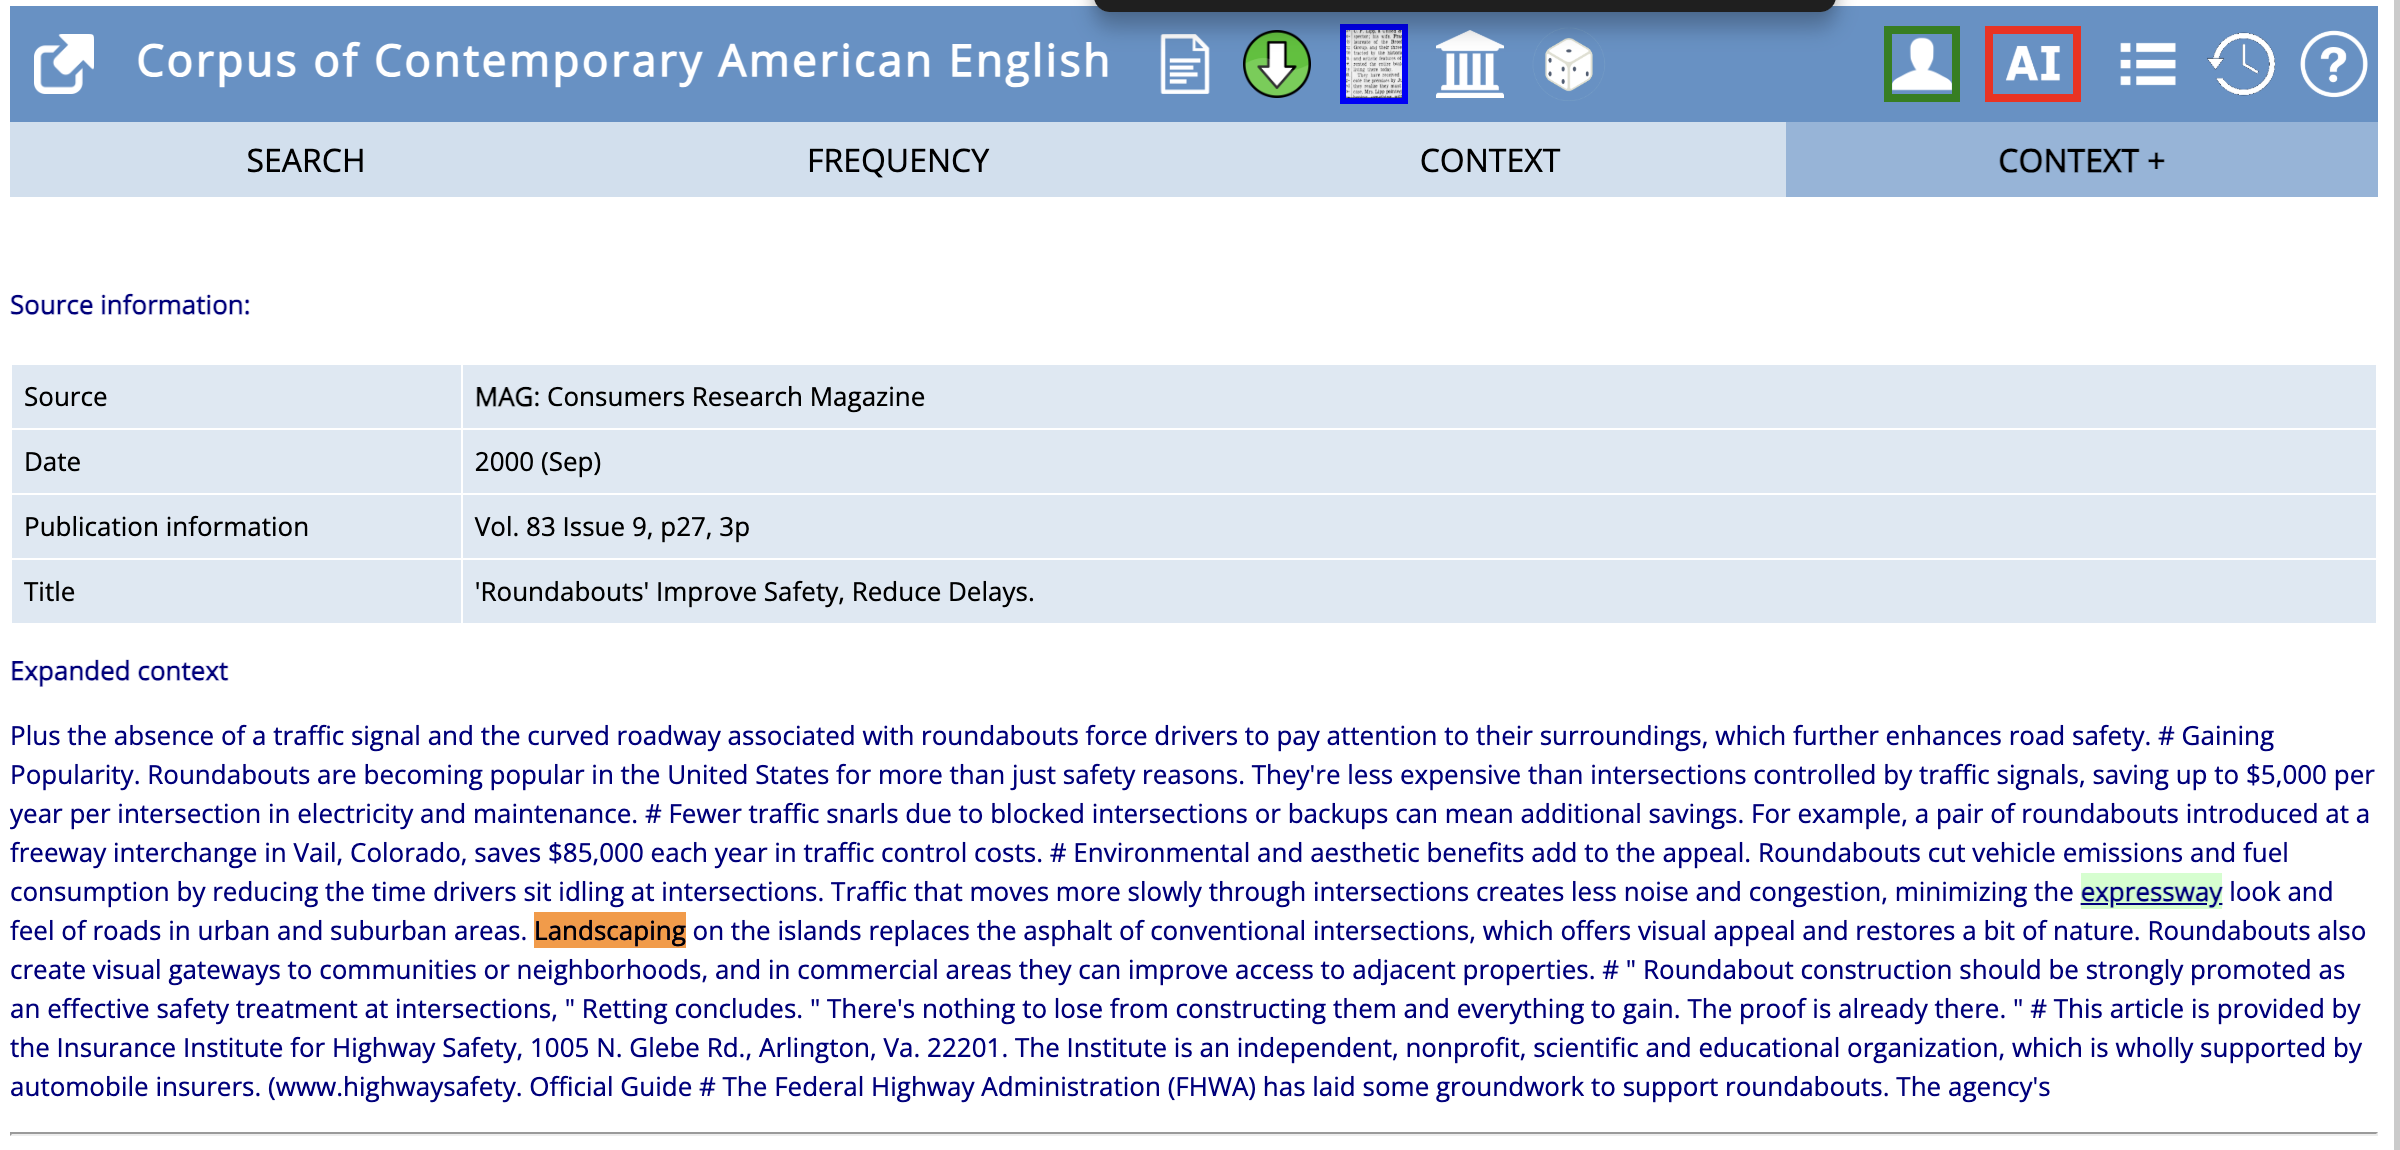

### Export results to excel for analysis

- your AWS Bedrock queries cost money, and query results are cached locally for reuse to save costs on re-runs for the same KWIC data.
- export the collection of classifications to an Excel file for further analysis.

In [91]:
# Export results to Excel format (matching Lee & Egbert's original format)
excel_file = export_classifications_to_excel(
    classification_results, 
    landscaping_keyword,
    filename=None  # Auto-generate filename
)

print(f"\n✅ Results exported and ready for analysis!")
print(f"📁 File: {excel_file}")


📊 Classifications exported to Excel: lee_egbert_landscaping_classifications.xlsx
   Total lines: 2149

📈 Classification Summary:
   includes_botanical_elements:
      Indeterminate: 1425 (66.3%)
      Yes: 679 (31.6%)
      No: 45 (2.1%)
   includes_non_botanical_elements:
      Indeterminate: 1758 (81.8%)
      Yes: 352 (16.4%)
      No: 39 (1.8%)
   improves_aesthetics:
      Indeterminate: 1740 (81.0%)
      Yes: 371 (17.3%)
      No: 38 (1.8%)
   improves_function:
      Indeterminate: 1826 (85.0%)
      Yes: 288 (13.4%)
      No: 35 (1.6%)

✅ Results exported and ready for analysis!
📁 File: lee_egbert_landscaping_classifications.xlsx


In [92]:
# Display first few rows of results
classification_results.head(10)


,line_id,genre,year,genre_year,filename_id,concordance_line,keyword,includes_botanical_elements,includes_non_botanical_elements,improves_aesthetics,improves_function,evidence
0,1,mag,1993,mag_1993,181_1,"Results suffered last year , when Rollins trie...",landscaping,Yes,Indeterminate,Indeterminate,Indeterminate,The phrase 'landscaping and lawn-care services...
1,2,mag,1993,mag_1993,314_1,"over your friends and relatives , greet import...",landscaping,Indeterminate,Indeterminate,Indeterminate,Yes,"The phrase ""landscaping ... will accommodate t..."
2,3,mag,1993,mag_1993,317_1,"Lower food prices , less landscape maintenance...",landscaping,Yes,Indeterminate,Indeterminate,Yes,"Mentions ""plants"", ""herbs and flowers"" (botani..."
3,4,mag,1993,mag_1993,317_2,"a significant portion of urban waste , up to 3...",landscaping,Yes,No,No,Yes,Mentions growing food (plants) and cites funct...
4,5,mag,1993,mag_1993,317_3,crops from the same ground . Many of the peris...,landscaping,Yes,Indeterminate,Indeterminate,Yes,"Mentions fruit trees (sapotes, mulberries, loq..."
5,6,mag,1993,mag_1993,317_4,as long as there is sufficient water . Wastewa...,landscaping,Yes,Yes,Indeterminate,Yes,"Mentions ""multipurpose trees and varieties"" (b..."
6,7,mag,1993,mag_1993,317_5,. Apples and nuts mature in the fall . Midwint...,landscaping,Yes,No,Indeterminate,Yes,"Mentions apples, nuts, persimmons, chestnuts, ..."
7,8,mag,1993,mag_1993,317_6,Christmas baskets . Other citrus and avocado v...,landscaping,Yes,Indeterminate,Indeterminate,Yes,"Mentions ""citrus and avocado varieties"" (plant..."
8,9,mag,1993,mag_1993,317_7,the resource deficit afflicting conventional a...,landscaping,Yes,Indeterminate,Indeterminate,Yes,"Mentions ""edible landscaping"", ""trees and plan..."
9,10,mag,1993,mag_1993,317_8,"reduce many problems with pesticides , herbici...",landscaping,Yes,Indeterminate,Indeterminate,Yes,"Mentions ""trees and plants"" (botanical) and de..."


## Get Summary Statistics of Classifications

In [93]:
# Display summary statistics for all four criteria
print("📊 CLASSIFICATION SUMMARY STATISTICS")
print("=" * 70)

criteria = ['includes_botanical_elements', 'includes_non_botanical_elements',
           'improves_aesthetics', 'improves_function']

for criterion in criteria:
    if criterion in classification_results.columns:
        print(f"\n{criterion.upper().replace('_', ' ')}:")
        counts = classification_results[criterion].value_counts()
        total = len(classification_results)
        
        for value in ['Yes', 'No', 'Indeterminate']:
            count = counts.get(value, 0)
            pct = (count / total * 100) if total > 0 else 0
            print(f"  {value:15s}: {count:5d} ({pct:5.1f}%)")


📊 CLASSIFICATION SUMMARY STATISTICS

INCLUDES BOTANICAL ELEMENTS:
  Yes            :   679 ( 31.6%)
  No             :    45 (  2.1%)
  Indeterminate  :  1425 ( 66.3%)

INCLUDES NON BOTANICAL ELEMENTS:
  Yes            :   352 ( 16.4%)
  No             :    39 (  1.8%)
  Indeterminate  :  1758 ( 81.8%)

IMPROVES AESTHETICS:
  Yes            :   371 ( 17.3%)
  No             :    38 (  1.8%)
  Indeterminate  :  1740 ( 81.0%)

IMPROVES FUNCTION:
  Yes            :   288 ( 13.4%)
  No             :    35 (  1.6%)
  Indeterminate  :  1826 ( 85.0%)


## Cross-tabulation Analysis

Let's perform some cross-tabulation analysis to understand relationships between the classification criteria, similar to what Lee & Egbert would analyze.


In [94]:
# Cross-tabulation: Botanical vs Non-Botanical Elements
print("🔬 CROSS-TABULATION: Botanical vs Non-Botanical Elements")
print("=" * 70)
crosstab_elements = pd.crosstab(
    classification_results['includes_botanical_elements'],
    classification_results['includes_non_botanical_elements'],
    margins=True
)
print(crosstab_elements)
print()

# Cross-tabulation: Aesthetics vs Function
print("🔬 CROSS-TABULATION: Aesthetics vs Function")
print("=" * 70)
crosstab_purpose = pd.crosstab(
    classification_results['improves_aesthetics'],
    classification_results['improves_function'],
    margins=True
)
print(crosstab_purpose)
print()

# Genre distribution of classifications
print("🔬 GENRE DISTRIBUTION: Botanical Elements by Genre")
print("=" * 70)
genre_botanical = pd.crosstab(
    classification_results['genre'],
    classification_results['includes_botanical_elements'],
    margins=True
)
print(genre_botanical)


🔬 CROSS-TABULATION: Botanical vs Non-Botanical Elements
includes_non_botanical_elements  Indeterminate  No  Yes   All
includes_botanical_elements                                  
Indeterminate                             1301   1  123  1425
No                                           9   7   29    45
Yes                                        448  31  200   679
All                                       1758  39  352  2149

🔬 CROSS-TABULATION: Aesthetics vs Function
improves_function    Indeterminate  No  Yes   All
improves_aesthetics                              
Indeterminate                 1525   6  209  1740
No                              14  15    9    38
Yes                            287  14   70   371
All                           1826  35  288  2149

🔬 GENRE DISTRIBUTION: Botanical Elements by Genre
includes_botanical_elements  Indeterminate  No  Yes   All
genre                                                    
acad                                   122   5   47   174
blo